# Training MODEL to play 2048

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from game_2048 import game_2048
import random
import copy
import matplotlib.pyplot as plt

/home/laserhammer/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## NN for Estimation of action value function
The small neural network defined here gives is used to estimate the action value function for the 4 possible actions (up,down,left.right). The model will be evaluated over different NN architecture (activation functions and depth of layers). In this approach as there are no image input and the states are finite, I am using numeric data to represent the state (as this is suppose to be a Project based on research paper Playing with ATARI). Later implimentations will also have same games state value in terms of image rather than numeric data (in this case the matrix itself)

In [2]:
class Small_neural_net(nn.Module):
    def __init__(self):
        super(Small_neural_net,self).__init__()
        self.layer1 = nn.Linear(16,32)
        self.layer2 = nn.Linear(32,48)
        self.layer3 = nn.Linear(48,64)
        self.layer4 = nn.Linear(64,10)
        self.layer5 = nn.Linear(10,4)
    
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = self.layer5(x)
        return x

### Initialise important parameters

In [3]:
def normalise_input(state_matrix,n):
    one = np.ones_like(state_matrix)
    state_matrix = np.add(state_matrix,one)
    filled = np.full_like(state_matrix,n)
    normaised_state = np.log2(state_matrix)/np.log2(filled)

    normaised_state = torch.tensor(normaised_state.flatten(), dtype=torch.float32).unsqueeze(0)
    
    return normaised_state



def eta_greedy(greedy,action_values):
    action_values = action_values.tolist()
    actions = [0,1,2,3]
    if random.random()< greedy:
        return random.choice(actions)
    else:
        max_val = max(action_values)
        max_indices = [i for i, v in enumerate(action_values) if v == max_val]
        return random.choice(max_indices)

        




### Loss Function: 
The loss function used will be MSE and as we are estimating action value functions we will be taking from the experiecnce buffer (this will be a finite buffer, you will know why)

The NN will run till the terminal state is hit that is when the matrix dosent change after actions are 

In [4]:
reward = 0
runs = 10
model = Small_neural_net()
criteriation = nn.MSELoss()
game = game_2048()
buffer_game = game_2048()
model_eval = copy.deepcopy(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
gamma = 0.99
replay_memory = []
action = [0,1,2,3]
loss_his = []
reward_his = []

In [5]:
#filling the buffer
for i in range(100):
        #initialise the replay memory
        #run the model with copy to buffer up memory
        s_t = buffer_game.matrix.copy()
        a_t = random.choice(action)
        r_t = buffer_game.run(a_t)
        s_t_1 = buffer_game.matrix.copy()
        #store the replay in the memory
        replay_memory.append([s_t,a_t,r_t,s_t_1])
        if r_t == -1:
            buffer_game.initialise()
        

In [ ]:
for run in tqdm(range(runs)):
    l = []
    r_h =  []
    flag = 0
    game.initialise()
    while flag != -1:
        #train the model
        s_t = game.matrix.copy()
        #predict action value function
        q_t = model(normalise_input(s_t,2048))
        #choose an action based on action value functions predicted (throught eta greedy)
        a_t = eta_greedy(0.2,q_t)
        r_t = game.run(a_t)
        s_t_1 = game.matrix.copy()
        #save the the experience in buffer 
        replay_memory.pop()
        replay_memory.append([s_t,a_t,r_t,s_t_1])

        #training
        #sample mini batch from replay
        experience = random.choice(replay_memory)
        if(run%2 == 0):
            model_eval = copy.deepcopy(model)
        with torch.no_grad():
            s_m,a_m,r_m,s_m_1 = experience
            q_t_1 = model_eval(normalise_input(s_m_1,2048))
            q_max = max(q_t_1[0])
            # if the next state in experience is terminal then there is no future reward
            # in this game to indicate terminal sate the reward outputs -1 
            # (this has to be treated as a flag and not a reward hence the override with 0)
            if(r_m == -1):
                y = 0
            else:
                r = torch.tensor(r_m, dtype=torch.float32)
                gamma = torch.tensor(gamma, dtype=torch.float32)
                y = r_t + gamma*q_max
        # now that the predicted value has been calculated train the model
        #the target value is a tensor of size (1,4), so the update has to happen for the chosen action
        # taht is the action value update has to happen from the chosen action
        target = q_t.clone().detach()
        target[0,a_t] = y
        loss = criteriation(q_t,target)
        l.append(loss.item())
        r_h.append(r_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #append the loss and reward for model train evaluation
        flag = r_t
    loss_his.append((sum(l)/len(l)))
    reward_his.append((sum(r_h)/len(r_h)))
    


  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_52104/2676469454.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gamma = torch.tensor(gamma, dtype=torch.float32)


0.0010368137154728174
0.0009195853199344128
12.577640695633212
13.478206756160944
10.78265220184112
89.79586658096134
97.59212924085192
93.4145202131258
83.03513330385087
75.13323835878073
74.1254460987584
67.94832559216069
82.41628510941034
77.67233858609238
82.09251336882946
76.96173129897133
72.43457076042625
69.29976918880887
65.86290053240324
62.569755505920156
114.63710671322752
110.1536077580675
116.67893546508766
114.48277548899311
111.34420574140604
107.06173629231672
103.09648715314549
101.70127013934034
98.19432992495456
99.721566555223
98.56744129938573
95.98663789529459
93.07795202611668
91.39744575117143
94.38586040451408
91.7640309545618
89.28392201702977
99.83559666378557
97.27570967751078
94.84381733376621
92.5305541179666
200.39545628926504
195.73509738851774
211.95471736752515
209.46827400225072
205.29008748444852
200.92221405716202
198.0660088415648
194.02466664982566
210.63250339495414
206.81555901309315
202.83833820110888
202.8364552284354
218.04959396986484
214.3

 10%|█         | 1/10 [00:01<00:09,  1.01s/it]

1095.8686432569025
1092.7901257435942
1090.2220951241372
1087.5894474899042
1084.5135081978628
1081.7790475842762
1078.6292481366875
1075.9144211399532
1072.9173393388346
1069.973423515563
1067.0886104920226
1064.462168022969
1062.0173301834018
1059.8188850517818
1057.317942474932
1054.786450130669
1052.9705011763572
1050.2581487256014
1047.7300037583602
1045.4587601487278
1042.927142981754
1040.1943877110841
1037.7363796260981
1035.199669280113
1033.123412484614
1030.7994928254525
1028.5958798577324
1025.766193020463
1022.9738256286341
1020.3227157027961
1017.5535435360845
1014.7824039271038
1012.2646871410192
1011.0231232856553
1008.425172318015
1005.718668564331
1003.1214763778715
1000.5902734499717
998.2080996502094
995.9571580804391
993.5497616295052
991.6422128443577
1093.525031477706
1090.6473979245588
1087.9221894465195
1085.0668387711148
1082.267887805545
1079.442506679599
1076.6439885064904
1073.885812627118
1071.1044692489868
1068.3515647502009
1065.8798886749646
1063.306177

 20%|██        | 2/10 [00:01<00:05,  1.34it/s]

824.5794169220312
820.7969542533814
817.0515944802434
814.0768047535797
810.7402249361431
808.010270009959
804.5539007002301
801.0410919984907
797.6101500730884
794.3652943243335
791.405583884469
788.0561186501174
784.8556777116355
783.393993081979
805.1891984183395
801.7244766834839
798.3710052104824
795.193815232072
791.9927131660288
788.7690462507786
785.8297459573533
782.6393530316061
779.3683529049631
776.1466715742994
772.936936364614
769.7934343893517
766.6267836373381
763.5470754391687
761.0446244332107
757.9691867668307
755.0536883577015
752.0117876846799
749.690912232327
751.7274786615227
749.5156813171136
746.6772068502268
744.3539338780814
742.0670233232627
739.2327763286149
736.4710587421291
733.6861107609011
731.1462538011175
728.4358512931669
725.8287109750829
723.3324127571655
721.6258431727512
718.9702915954815
716.2775308227764
713.881401012515
711.7106583467864
709.1494963365412
707.0182919084001
705.3340624069945
703.1302627925386
700.5387991638069
698.1712844417681

 30%|███       | 3/10 [00:04<00:12,  1.79s/it]

2007.4458758408546
2006.135567389182
2004.7717596542263
2003.4059352552279
2002.0414479866304
2000.749486510583
1999.4113326522895
1998.0563839931829
1996.7091254656045
1995.3715930324267
1994.0420435072735
1992.700866968119
1991.466012618661
1990.16520473445
1988.8224838585877
1987.6732661247863
1986.3308202825815
1985.0049905234584
1989.9765054010152
1988.6713597642802
1987.3497490219477
1986.0342460752863
1984.6988027967127
1983.4112767219349
1982.4063668022038
1981.0957483161415
1986.850260791055
1985.5197880821493
1992.3997538481383
1991.0663301278946
2034.966323380821
2033.6067832486012
2032.2483562637583
2030.8953788694698
2029.6358811334994
2028.4053760931727
2027.1467927117471
2025.9070580320272
2024.6092495085045
2023.2873583733167
2021.9435737191804
2020.663673700776
2019.3254973712794
2018.0575146018673
2016.9291608730548
2015.912844186919
2014.6707310694067
2013.4717224379674
2012.389505712929
2011.288018481758
2009.9950850458847
2008.757525975803
2007.7466035491682
2006.7

 40%|████      | 4/10 [00:05<00:09,  1.55s/it]

1542.5081321244243
1539.9898852903991
1537.9618863927965
1535.6628909469043
1533.089395354334
1530.9340695394158
1528.3094303914604
1525.7975573055257
1523.4936166255
1521.0728611988557
1518.7741102059456
1516.4213880880598
1513.8392929101417
1511.3762791740974
1508.7975841481814
1506.6883635953377
1504.1659689973283
1501.8808669187702
1499.3357921263303
1497.2342378760734
1494.7163972873118
1492.2441360788018
1489.8518770987716
1487.4432539565603
1485.157130960088
1482.957101865268
1480.800183575526
1478.3375880923593
1475.875334163942
1473.472009341092
1471.0804944684319
1468.8121411871928
1466.431090124038
1464.007574905677
1461.6732688326233
1459.5806823631467
1457.2305087555376
1454.9102558218963
1452.5562824138246
1450.1954929471972
1447.8487898382466
1445.570456182624
1443.2202624725576
1440.989343486024
1439.0743151835786
1436.7582448632422
1434.4877359745938
1432.171206755513
1430.0004128602607
1427.8098600567614
1425.539168409249
1423.7620302747168
1421.5424812749773
1419.308

 50%|█████     | 5/10 [00:07<00:08,  1.73s/it]

2205.103953123222
2202.6973297496484
2200.1791656300434
2197.7083532521374
2195.202752310001
2192.9935582077983
2190.36099653152
2187.7636995991315
2185.1576675781616
2182.559416864587
2179.9825150959196
2177.468916836213
2174.873602278577
2172.2998930297813
2169.8134871268758
2167.272449441557
2164.70590198475
2162.672317643268
2160.2302764198153
2157.678060554833
2155.151438836472
2152.6142731686755
2150.2191111949874
2147.713754867773
2145.190890324909
2142.685535957383
2140.2094507478414
2137.8171266430104
2136.574447877611
2134.09479552713
2131.6118838242865
2129.127507200914
2126.7107059203704
2124.260408623302
2121.891444570678
2120.036710053226
2117.737193093267
2115.348062744875
2112.9667766902076
2110.5302182053583
2108.100607982584
2105.676428953651
2103.3095425566544
2100.9745502214596
2098.565083157209
2096.1913225765898
2094.1338412584446
2091.7481497949266
2089.3722882271086
2087.0369614090823
2085.4611279363917
2083.1661490758897
2080.8241432931236
2078.541120576344
207

 60%|██████    | 6/10 [00:09<00:06,  1.69s/it]

1316.9474616838247
1314.9903909397738
1313.3020304266697
1311.908380655988
1309.5240605891076
1307.4233905652063
1305.6992206175537
1303.431069407454
1301.725793097058
1299.3630700669285
1297.5760025037825
1295.6898896576267
1293.8082017660138
1291.6907434414868
1289.9295011351555
1288.817895832979
1287.1675393520177
1286.8318706074492
1284.647812461469
1282.3613195405258
1280.4608412403895
1279.1243924978785
1276.891020785301
1274.6308362267116
1272.3959542944153
1270.6749957798645
1269.1562057107842
1267.998377256284
1265.8894596136304
1264.8273886901031
1262.6197585361012
1260.5521067875661
1258.408978663897
1256.2367732502855
1254.058912118704
1251.882481472494
1249.716556394255
1247.6218908473795
1245.8793251655775
1243.8888490583668
1241.7508292217979
1239.8689244534241
1237.8451010255928
1235.9520944123497
1234.423248924689
1232.520859527435
1230.5788248583747
826.7361450195312
557.7970123291016
735.7170918782552
649.9756927490234
689.6247924804687
819.0069885253906
790.15949358

 70%|███████   | 7/10 [00:10<00:04,  1.35s/it]

937.088772836361
935.0675871703536
933.359071365379
931.606847319726
929.6076909981633
928.6474556103569
950.0319082459384
948.3976556240683
977.6003002397619
975.5247352913502
973.4893482403803
971.9393691276211
969.9087067400421
967.8703828485958
965.9600822520424
964.0092019190646
962.0470358572812
960.0902157283344
958.7781596199242
957.1134129339412
955.3716769728491
953.6926499850081
951.7231104482863
949.9040082450324
948.0370225602774
946.1272985519636
944.3757830184569
942.4535335188328
940.8164906356352
939.4418353559109
937.8032794997525
935.9965587900878
934.1569929654364
932.7557915688108
931.432990115551
930.4323010310866
928.5885200931908
926.7310704829523
925.3618622177189
923.9131529467375
922.0850100771904
921.0482639638916
919.2537040945148
917.6113739398983
916.4749786098076
924.4292335367361
922.6247445568389
920.8150141621448
919.1124760565167
917.403484873862
915.9894746833544
914.3745333719038
912.7049964349156
912.0170042827817
910.2551934153597
908.77163668325

 80%|████████  | 8/10 [00:12<00:03,  1.54s/it]

1192.7435957223936
1191.3593358512564
1190.0424030545726
1188.6676277518302
1187.6313881162725
1186.5056039195676
1185.179299601657
1183.9148443908423
1182.9235962260857
1182.104482581679
1180.8250343853122
1179.6386966761531
1178.3721599569305
1177.032924828319
1175.7240159570313
1175.079920244029
1174.015970543047
1172.7475591915684
1171.4132621161916
1170.1101445262445
1169.11947814122
1168.0805996982917
1166.9617584437735
1165.6525041566442
1164.4523871769886
1163.1745101738059
1162.0222663094123
1160.7122991833166
1159.408195678118
1158.6464412982966
1157.8634141526718
1156.5807936805047
1155.2839029405282
1154.0221097421247
1152.820860573856
1151.9301841664396
171.4877471923828
574.655647277832
578.1098887125651
892.0754585266113
768.6345489501953
825.1786727905273
746.7222006661551
913.0593547821045
870.7950761583116
832.2597061157227
866.1991868452592
830.9720751444498
841.9100189208984
782.7061600003924
754.2842027028402
715.8639980554581
675.6368909723618
768.0854491127861
72

 90%|█████████ | 9/10 [00:13<00:01,  1.44s/it]

1959.75043263664
1956.9596651557558
1953.1859506536857
1949.83456880534
1946.114668533228
1942.7106107052587
1938.9917981752712
1935.2894740898105
1931.8009499375366
1928.1735183389067
1924.8287494608876
1921.1764705914948
1917.6093807108496
1913.984750334653
1910.568927010761
1907.0130185252885
1903.477775682892
1899.9083318702856
1896.6611477615813
1893.261018133756
1889.746756627635
1888.418912723446
1885.018631310414
1881.7647075362593
1878.329044164697
1880.2582109976297
1876.7958488514194
1873.3991312108337
1870.013198892566
1866.6340425348412
1863.246287232061
1859.84216607089
1856.5012045430135
1853.1890109503115
1850.08855873469
1846.7500119184754
1843.4337143415687
1447.097412109375
1416.39453125
984.4655812581381
944.9638252258301
827.7100494384765
718.7322336832682
647.2665405273438
575.5315380096436
602.4198048909506
565.1719284057617
565.4384696266868
545.9601198832194
544.370362501878
572.8660332815988
552.2539723714193
536.2929182052612
509.4573853436638
544.56889724731

100%|██████████| 10/10 [00:15<00:00,  1.51s/it]

1295.6255820994745
1293.9818968143015
1292.3796369772056
1291.5053431329306
1290.7242988822193
1290.1190777474642
1288.648989421218
1287.3102496048125
1285.6974818055196
1285.3252338667671
1284.122525266548
1282.7983239969276
1281.3330933447387
1279.7373128860654
1278.2548863050852
1276.6892247633507
1275.1322812350631
1274.1849653322959
1272.691739506994
1271.1796480413761
1269.6873484372265
1268.4847598730398
1266.9331667920774
1277.4841679943404
1275.94988429056
1274.6367036279846
1273.5393462661507
1272.4327662377218
1271.4081379199527
1269.9213748404268
1268.3707132546147
1267.168079500624
1266.0740622713802
1264.5300718749884
1262.9900849063424
1262.3844006360744
1261.1851866680254
1259.6638671533437
1258.5363974268228
1258.1365269059281
1256.827199914335
1256.211242859246
1255.3771774228583
1253.8809266714165
1253.0993661998561


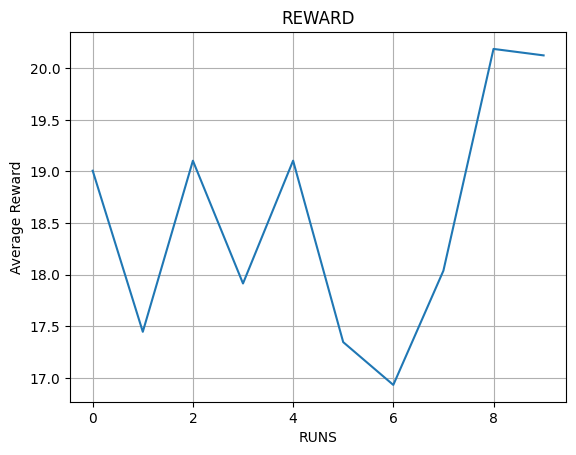

In [7]:
plt.xlabel("RUNS")
plt.ylabel("Average Reward")
plt.plot(reward_his)
plt.title("REWARD")
plt.grid(True)
plt.show()

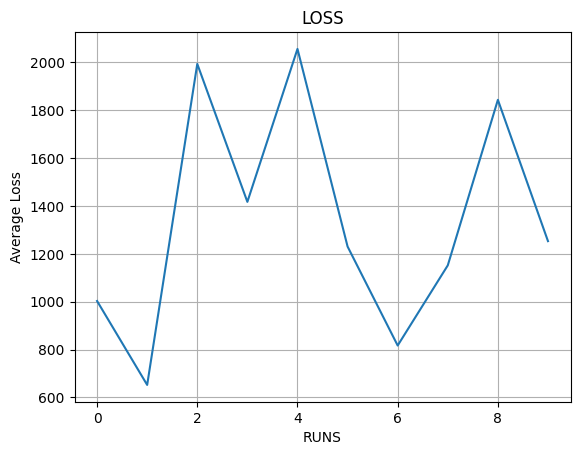

In [8]:
plt.xlabel("RUNS")
plt.ylabel("Average Loss")
plt.plot(loss_his)
plt.title("LOSS")
plt.grid(True)
plt.show()